# FoCus Dataset

In [1]:
DATASET = "FoCus"
SET = "train"           #train,   valid   
MAX_LENGTH = 110

In [2]:
import pandas as pd
import json

with open(f'./datasets/{DATASET}/{SET}_focus.json') as f:
    data = json.load(f)

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def convertToDialogue(my_list):
    formatted_string = ""
    for index, item in enumerate(my_list):
        if index % 2 == 0:
            user = "User1"
        else:
            user = "User2"
        formatted_string += f"{user}: {item}\n"
    formatted_string = formatted_string.rstrip("\n")
    return formatted_string

flattened_data = []
data_list = data['data']
for entry in data_list:
    persona =  "".join(entry['persona'])
    list_length = len(entry["utterance"])
    last_utterance = entry["utterance"][-1]
    dialogue_key = f"dialogue{list_length}"
    last_item = last_utterance[dialogue_key]
    flattened_data.append({
                'dialogID': entry['dialogID'],
                'persona': persona,
                'utterance': convertToDialogue(last_item)
            })

dataset = pd.DataFrame(flattened_data)
print(dataset.shape)
dataset.head()

(12484, 3)


,dialogID,persona,utterance
0,Z8RPC24EURS4,I like to go to Church.I am Roman Catholic.I w...,"User1: Wow, this is amazing! What is this?\nUs..."
1,9KDV6LSLWNAX,I like living in a city.I don't hope to ever v...,"User1: I know this place, but I don't remember..."
2,U2VHOEDA278F,I want to visit Mexico.I am interested in the ...,"User1: I know this place, but I don't remember..."
3,82ZP2M9AL6U0,I am afraid of bears.I like valleys.I live in ...,User1: Where is this place?\nUser2: This place...
4,FOZE4Q84M3RX,I would like to visit New Zealand.I would like...,User1: I think I've been there before but I do...


In [4]:
dataset.replace(r'\*\*', '', regex=True, inplace=True)
dataset.replace(r'\r', '', regex=True, inplace=True)
dataset.replace("'", "", regex=True, inplace=True)

dataset.dropna(inplace=True)

# Function to split the conversation
def split_conversation(conv_str):
    utterances = conv_str.split("\n")
    context = "\n".join(utterances[:-1])
    response = utterances[-1]
    return context, response

new_rows = []
for index, row in dataset.iterrows():
    context, response = split_conversation(row['utterance'])
    new_row = {
        'personas': row['persona'],
        'context': context,
        'act_response': response
    }
    new_rows.append(new_row)

new_df = pd.DataFrame(new_rows)

print(new_df.shape)
new_df.head(10)

(12484, 3)


,personas,context,act_response
0,I like to go to Church.I am Roman Catholic.I w...,"User1: Wow, this is amazing! What is this?\nUs...",User2: It is in Texas state.
1,I like living in a city.I dont hope to ever vi...,"User1: I know this place, but I dont remember ...","User2: Of course, Captain William Cornwallis S..."
2,I want to visit Mexico.I am interested in the ...,"User1: I know this place, but I dont remember ...","User2: Well, in this rainforest, especially th..."
3,I am afraid of bears.I like valleys.I live in ...,User1: Where is this place?\nUser2: This place...,"User2: Not only it, but there are various othe..."
4,I would like to visit New Zealand.I would like...,User1: I think Ive been there before but I don...,"User2: Prior to a 2006–2008 street upgrade, Co..."
5,I wish to build a dam in Australia.I like Lake...,User1: I think Ive been there before but I don...,User2: The property is owned by WaterNSW which...
6,I like enginering.I have plans to visit Austra...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Yes, it was added to the Queensland Her..."
7,I want to go to Ontario.I am visiting Canada.I...,User1: Where is this place?\nUser2: This actua...,User2: The meltwater that created the lake is ...
8,I would love to vist Divljana Monastery again....,User1: I think Ive been there before but I don...,User2: Acoording to various records and source...
9,I am interested in ecozone.I would like to vis...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Mountains of volcanic rock range in age...


In [5]:
max_word_count = new_df['act_response'].dropna().apply(lambda x: len(str(x).split())).max()
print("Maximum number of words:", max_word_count)

Maximum number of words: 159


In [6]:
new_df.drop(
    new_df[~new_df['act_response'].apply(lambda x: len(str(x).split()) <= MAX_LENGTH)].index,
    inplace=True
)

In [7]:
if SET == "train":
    
    df = new_df.sample(n=1500, random_state=44)
    print("\nMissing Values:\n", df.isnull().sum())
else:
    df = new_df


Missing Values:
 personas        0
context         0
act_response    0
dtype: int64


In [8]:
# Calculate minimum and maximum number of words in each column
min_persona_length = df['personas'].apply(lambda x: len(x.split())).min()
max_persona_length = df['personas'].apply(lambda x: len(x.split())).max()

min_context_length = df['context'].apply(lambda x: len(x.split())).min()
max_context_length = df['context'].apply(lambda x: len(x.split())).max()

min_response_length = df['act_response'].apply(lambda x: len(x.split())).min()
max_response_length = df['act_response'].apply(lambda x: len(x.split())).max()

# Print the lengths in min-max format
print(f"Persona Length (in words): {min_persona_length}-{max_persona_length}")
print(f"Context Length (in words): {min_context_length}-{max_context_length}")
print(f"Response Length (in words): {min_response_length}-{max_response_length}")

Persona Length (in words): 11-68
Context Length (in words): 48-591
Response Length (in words): 2-109


In [9]:
print(df.isnull().sum())

df.dropna(inplace=True)

# Save the prompts
df.to_csv(f'./Prompts/{DATASET}-{SET}.csv', index=False)

print(df.shape)
df.head(2)

personas        0
context         0
act_response    0
dtype: int64
(1500, 3)


,personas,context,act_response
9495,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...
8355,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Yes! An episode from ChuckleVision and ...


# DPO Dataset

## Set parameters

In [1]:
DATASET = "FoCus"

LLM_names = [
    "Qwen2-7B-Instruct",
    "Qwen2-5B-Instruct",
    "Mistral-7B-Instruct",
    "Llama3-1-8B-Instruct",
    "gpt-3.5-turbo",
    "gpt-4o-mini",
    "gpt-4-turbo"
]

_COT = ""                       # "", "-COT"

## Failed Responses

In [2]:
import pandas as pd
import os

# Load the shared prompt data (same for all LLMs)
prompt_path = os.path.join("Prompts", f"{DATASET}-train.csv")
try:
    prompt_df = pd.read_csv(prompt_path)
    print(f"Loaded prompt data | Shape: {prompt_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Prompt file not found: {prompt_path}")

# Directory where LLM outputs are stored
base_dir = os.path.join("Raw Responses", DATASET)

# Container for all model outputs (with prompts merged)
all_dfs = []

# Load and horizontally merge prompt data for each LLM file
for LLM_name in LLM_names:
    file_path = os.path.join(base_dir, f"{LLM_name}-train{_COT}.csv")
    try:
        df = pd.read_csv(file_path)
        if len(df) != len(prompt_df):
            raise ValueError(f"❌ Mismatch in rows: {LLM_name}-train{_COT}.csv has {len(df)} rows, but prompt file has {len(prompt_df)}.")
        
        df = pd.concat([prompt_df, df], axis=1)  # Horizontal merge
        df["source_model"] = LLM_name + _COT     # Track source model
        print(f" Merged: {LLM_name}-train{_COT}.csv | New shape: {df.shape}")
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"❌ File not found: {LLM_name}-train{_COT}.csv")

# Vertically combine all model data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\n Final Combined DataFrame shape:", combined_df.shape)
    display(combined_df.head(3))
else:
    print("\n⚠️ No files loaded. combined_df will not exist.")


Loaded prompt data | Shape: (1500, 3)
 Merged: Qwen2-7B-Instruct-train.csv | New shape: (1500, 6)
 Merged: Qwen2-5B-Instruct-train.csv | New shape: (1500, 6)
 Merged: Mistral-7B-Instruct-train.csv | New shape: (1500, 6)
 Merged: Llama3-1-8B-Instruct-train.csv | New shape: (1500, 6)
 Merged: gpt-3.5-turbo-train.csv | New shape: (1500, 6)
 Merged: gpt-4o-mini-train.csv | New shape: (1500, 6)
 Merged: gpt-4-turbo-train.csv | New shape: (1500, 6)

 Final Combined DataFrame shape: (10500, 6)


,personas,context,act_response,gen_response,response_time,source_model
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...,"{\n ""response"": ""The HMS Plymouth, a frigate ...",4.184883,Qwen2-7B-Instruct
1,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Yes! An episode from ChuckleVision and ...,"{\n ""response"": ""Yes, this lighthouse has mad...",2.437124,Qwen2-7B-Instruct
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...,User2: Waterways are essential to the commerci...,"{\n ""response"": ""Acadiana's water system is q...",4.396471,Qwen2-7B-Instruct


In [3]:
import json
import re
import pandas as pd

def clean_gen_response_with_status(cell):
    if not isinstance(cell, str):
        return None, False

    # Step 1: Try full JSON parsing
    json_objects = re.findall(r'\{.*?\}', cell, re.DOTALL)
    for obj in json_objects:
        try:
            parsed = json.loads(obj)
            if "response" in parsed:
                return parsed["response"], True  # ✅ Successfully parsed JSON
        except json.JSONDecodeError:
            continue

    # Step 2: Fallback - Extract string after '"response": "'
    match = re.search(r'"response"\s*:\s*"(.*)', cell, re.DOTALL)
    if match:
        fallback_text = match.group(1)

        # Clean fallback text
        fallback_text = fallback_text.strip('"\n{} ').rstrip('.… ').strip()

        return fallback_text, False  # ❌ Not valid JSON, but usable fallback

    return None, False  # Nothing usable found

# Apply the function
combined_df[["cleaned_response", "json_success"]] = combined_df["gen_response"].apply(
    lambda x: pd.Series(clean_gen_response_with_status(x))
)

# Add word count
combined_df["response_word_count"] = combined_df["cleaned_response"].apply(
    lambda x: len(str(x).split()) if x else 0
)


In [4]:
# Count how many rows have cleaned_response == None
none_count = combined_df["cleaned_response"].isnull().sum()
print(f"Number of None values in 'cleaned_response': {none_count}")

Number of None values in 'cleaned_response': 153


In [5]:
# Drop rows with missing cleaned responses
combined_df = combined_df.dropna(subset=["cleaned_response"])

In [6]:
print("Successful responses:", len(combined_df[combined_df['json_success'] == True]))

print("Failed responses:", len(combined_df[combined_df['json_success'] == False]))

combined_df[combined_df['json_success'] == False].head(4)

Successful responses: 7363
Failed responses: 2984


,personas,context,act_response,gen_response,response_time,source_model,cleaned_response,json_success,response_word_count
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...,"{\n ""response"": ""The HMS Plymouth, a frigate ...",4.184883,Qwen2-7B-Instruct,"The HMS Plymouth, a frigate you've never been ...",False,74
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...,User2: Waterways are essential to the commerci...,"{\n ""response"": ""Acadiana's water system is q...",4.396471,Qwen2-7B-Instruct,"Acadiana's water system is quite diverse, feat...",False,77
4,I have visited many parks.I have interest in f...,"User1: Where is this place?\nUser2: Hi,If you ...",User2: Sure! The first occupants of the Mesa V...,"{\n ""response"": ""Mesa Verde National Park is ...",4.218754,Qwen2-7B-Instruct,Mesa Verde National Park is a fascinating dest...,False,67
7,I like historic places.Im interested in archit...,"User1: I know this place, but I dont remember ...","User2: Yes, not only Harlaxton Manor but also ...","{\n ""response"": ""Harlaxton Manor, a stunning ...",4.242917,Qwen2-7B-Instruct,"Harlaxton Manor, a stunning example of histori...",False,68


Simple DPO Dataset

In [7]:
import pandas as pd

# Function to generate a prompt
def create_dpo_prompt(personas, context, _COT):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if _COT == "-COT":
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if _COT == "-COT":
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt


import pandas as pd

# Step 1: Generate prompts
combined_df["prompt"] = combined_df.apply(lambda row: create_dpo_prompt(row["personas"], row["context"], _COT), axis=1)

# Step 2: Keep only necessary columns
df = combined_df[["prompt", "gen_response", "json_success"]]


In [8]:
# Step 3: Split by success/failure

df_true = df[df["json_success"] == True].rename(columns={"gen_response": "chosen"})
df_false = df[df["json_success"] == False].rename(columns={"gen_response": "rejected"})

# Step 4: Merge using group-wise cross join on the same prompt
merged_df = pd.merge(df_true, df_false, on="prompt", how="inner")

# Step 5: (Optional) Drop json_success columns — now redundant
simp_dpo_ds = merged_df[["prompt", "chosen", "rejected"]]

# Result: all (chosen, rejected) response pairs for each prompt
print(f"Total pairs: {len(simp_dpo_ds)}")

simp_dpo_ds.to_csv(f"dpo_datasets/{DATASET}_simple_dpo.csv", index=False)

simp_dpo_ds.head()

Total pairs: 12452


,prompt,chosen,rejected
0,I will provide you with a conversation context...,"{\n ""response"": ""Yes, this lighthouse has mad...","\nUnannotated Response:\n{\n ""response"": ""The..."
1,I will provide you with a conversation context...,"{\n ""response"": ""The formal garden at Greenmo...","{\n ""response"": ""I would love to visit Greenm..."
2,I will provide you with a conversation context...,"{\n ""response"": ""The Singapore Stone, a large...",Note: The response should not contain any pers...
3,I will provide you with a conversation context...,"{\n ""response"": ""The Singapore Stone, a large...","\nUnannotated Response:\n{\n ""response"": ""The..."
4,I will provide you with a conversation context...,"{\n ""response"": ""The Singapore Stone, a large...","{\n ""response"": ""The Singapore Stone is a sig..."


PsersoDPO Dataset

In [9]:
import re
import json


def is_single_valid_json_response(response_text: str) -> bool:
    """
    Ensures there is exactly one valid JSON object in the text
    and it contains the 'response' key.
    """
    # Regex pattern to find all JSON-like blocks
    json_pattern = r'\{.*?"response"\s*:\s*".*?".*?\}'
    matches = re.findall(json_pattern, response_text, re.DOTALL)

    # Must be exactly one match
    if len(matches) != 1:
        return False

    try:
        parsed_json = json.loads(matches[0])
        return "response" in parsed_json
    except json.JSONDecodeError:
        return False


In [10]:
for sample in simp_dpo_ds["chosen"].head(5).to_list():
    print(sample)
    print("Follows format:", is_single_valid_json_response(sample))
    print("-" * 50)


{
  "response": "Yes, this lighthouse has made appearances on television and in films. Its unique design and historical significance make it a popular subject for documentaries and dramas set in coastal areas. You might recognize it from its portrayal in various productions that highlight the beauty and challenges of the English coastline."
}
Follows format: True
--------------------------------------------------
{
  "response": "The formal garden at Greenmount Homestead features a variety of plants and flowers, creating a stunning display of beauty. It's a perfect spot for relaxation and enjoying nature's splendor."
}
Follows format: True
--------------------------------------------------
{
  "response": "The Singapore Stone, a large slab believed to date back to the 13th century, is a fascinating artifact. It's located near the mouth of the Singapore River, a place you enjoy. The stone bears an inscription that experts think might be in Old Javanese or Sanskrit. This suggests the isl

In [11]:
for sample in simp_dpo_ds["rejected"].iloc[400:403].to_list():
    print(sample)
    print("Follows format:", is_single_valid_json_response(sample))
    print("-" * 50)



{
  "response": "Windsor Great Park is a beautiful and historic place that you have likely visited before due to your love for exploring England. The park, which is not managed by The Royal Parks but instead by the Crown Estate, has a rich history tied to Windsor Castle and the royal family. You can even enter the park with your horse through a designated entrance. The park is a Grade I listed site, making it a protected and significant piece of English heritage. Its size is approximately 4,800
Follows format: False
--------------------------------------------------

Output:
{
  "response": "The St Johns Anglican Church in Dalby, Queensland, Australia, is a beautiful example of Gothic architecture. Its stained glass windows are a sight to behold. The current building was constructed in 1922-1923, but there were two previous structures built in 1876. As an Anglican and a lover of Gothic architecture, I would be thrilled to visit this church during my travels to Australia."

Follows for

In [12]:
# Step 1: Keep only rows with unsuccessful JSON parsing
rejected_df = combined_df[combined_df["json_success"] == False].copy()

rejected_df.drop(columns=["gen_response", "source_model", "json_success", "response_word_count"], inplace=True)

rejected_df.rename(columns={"cleaned_response": "gen_response"}, inplace=True)

# Step 2: Add default evaluation columns
rejected_df["Coh-UniEval"] = 0.0
rejected_df["C Score"] = -1
rejected_df["UE Score"] = 0
rejected_df["Persona Distance"] = 0.0

# Optional: View result
print(f"✅ Filtered DataFrame shape: {rejected_df.shape}")

print("Columns:", rejected_df.columns)
display(rejected_df.head())

✅ Filtered DataFrame shape: (2984, 10)
Columns: Index(['personas', 'context', 'act_response', 'response_time', 'gen_response',
       'prompt', 'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')


,personas,context,act_response,response_time,gen_response,prompt,Coh-UniEval,C Score,UE Score,Persona Distance
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ...",User2: The shit was controversial he scrapped ...,4.184883,"The HMS Plymouth, a frigate you've never been ...",I will provide you with a conversation context...,0.0,-1,0,0.0
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...,User2: Waterways are essential to the commerci...,4.396471,"Acadiana's water system is quite diverse, feat...",I will provide you with a conversation context...,0.0,-1,0,0.0
4,I have visited many parks.I have interest in f...,"User1: Where is this place?\nUser2: Hi,If you ...",User2: Sure! The first occupants of the Mesa V...,4.218754,Mesa Verde National Park is a fascinating dest...,I will provide you with a conversation context...,0.0,-1,0,0.0
7,I like historic places.Im interested in archit...,"User1: I know this place, but I dont remember ...","User2: Yes, not only Harlaxton Manor but also ...",4.242917,"Harlaxton Manor, a stunning example of histori...",I will provide you with a conversation context...,0.0,-1,0,0.0
8,I would like to visit Chile.I wish I knew more...,User1: I think Ive been there before but I don...,"User2: Yes, for example, this array participat...",4.253017,Absolutely! The Atacama Large Millimeter Array...,I will provide you with a conversation context...,0.0,-1,0,0.0


In [13]:
# First get unique context-persona pairs
rejected_unique_pairs = rejected_df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(rejected_unique_pairs)}")

rejected_unique_pairs

Total unique context-persona pairs: 1303


,personas,context
0,I want to learn more about the Royal Navy.I ha...,"User1: I know this place, but I dont remember ..."
2,I am interested in region.I would like to visi...,User1: Where is this place?\nUser2: This is Ac...
4,I have visited many parks.I have interest in f...,"User1: Where is this place?\nUser2: Hi,If you ..."
7,I like historic places.Im interested in archit...,"User1: I know this place, but I dont remember ..."
8,I would like to visit Chile.I wish I knew more...,User1: I think Ive been there before but I don...
...,...,...
5957,I love learning about other cultures.I would l...,"User1: I know this place, but I dont remember ..."
5962,I never left England.I live near a canal.I stu...,User1: Where is this place?\nUser2: This canal...
5980,I like sports.I have plans to go to Edinburgh....,"User1: I know this place, but I dont remember ..."
5983,I like viewpoints.I love hills.I live in Scotl...,"User1: Wow, this is amazing! What is this?\nUs..."


## Sucessful Responses

In [14]:
import pandas as pd

all_dfs = []  # List to store all dataframes

for llm in LLM_names:
    # Read the Excel file for each LLM
    ds = pd.read_excel(f"Metrics Results/{DATASET}/{llm}-train{_COT}-results.xlsx")

    all_dfs.append(ds)

# Combine all dataframes vertically
ds = pd.concat(all_dfs, axis=0, ignore_index=True)
len(ds)

10500

In [15]:
chosen_df = ds.dropna(subset=['gen_response'])

print("Columns:", chosen_df.columns)
print(len(chosen_df))
chosen_df.head(3)

Columns: Index(['personas', 'context', 'act_response', 'gen_response', 'response_time',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')
7363


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
1,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",Yes! An episode from ChuckleVision and another...,"Yes, this lighthouse has made appearances on t...",2.437124,0.999707,0,0,0.378951
3,I would like to visit Colorado.I love Bavarian...,"User1: I know this place, but I dont remember ...","Sure! The resort is located at 3,527 meters of...","Yes, ski lessons are available at Vail Ski Res...",4.071174,0.998872,1,0,0.670013
5,I would like to live in a house.I wish to visi...,User1: Where is this place?\nUser2: This is Gr...,"The formal garden contains a circular drive, w...",The formal garden at Greenmount Homestead feat...,1.804503,0.996803,0,1,0.457770


## Dataset Creation

In [16]:
print(chosen_df.isna().sum())

print(rejected_df.isna().sum())

personas            0
context             0
act_response        0
gen_response        0
response_time       0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64
personas            0
context             0
act_response        0
response_time       0
gen_response        0
prompt              0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64


In [17]:
# Concatenate chosen_df and rejected_df vertically
df = pd.concat([chosen_df, rejected_df], ignore_index=True)

# Print information about the operation
print(f"Shape of chosen_df: {chosen_df.shape}")
print(f"Shape of rejected_df: {rejected_df.shape}")
print(f"Shape of combined DataFrame: {df.shape}")

# Display the first few rows of the combined dataframe
df.head()

Shape of chosen_df: (7363, 9)
Shape of rejected_df: (2984, 10)
Shape of combined DataFrame: (10347, 10)


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance,prompt
0,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...",Yes! An episode from ChuckleVision and another...,"Yes, this lighthouse has made appearances on t...",2.437124,0.999707,0,0,0.378951,NaN
1,I would like to visit Colorado.I love Bavarian...,"User1: I know this place, but I dont remember ...","Sure! The resort is located at 3,527 meters of...","Yes, ski lessons are available at Vail Ski Res...",4.071174,0.998872,1,0,0.670013,NaN
2,I would like to live in a house.I wish to visi...,User1: Where is this place?\nUser2: This is Gr...,"The formal garden contains a circular drive, w...",The formal garden at Greenmount Homestead feat...,1.804503,0.996803,0,1,0.457770,NaN
3,I have seen sandstone.I would like to go to Si...,"User1: I know this place, but I dont remember ...",The Stone is now displayed at the National Mus...,"The Singapore Stone, a large slab believed to ...",3.734649,0.999467,1,0,0.473276,NaN
4,I love history.I like Pennsylvania.I like arch...,User1: I think Ive been there before but I don...,"Since you want to go to college, you might con...","Absolutely, College Hill Residential Historic ...",3.950015,0.998512,1,0,0.621743,NaN


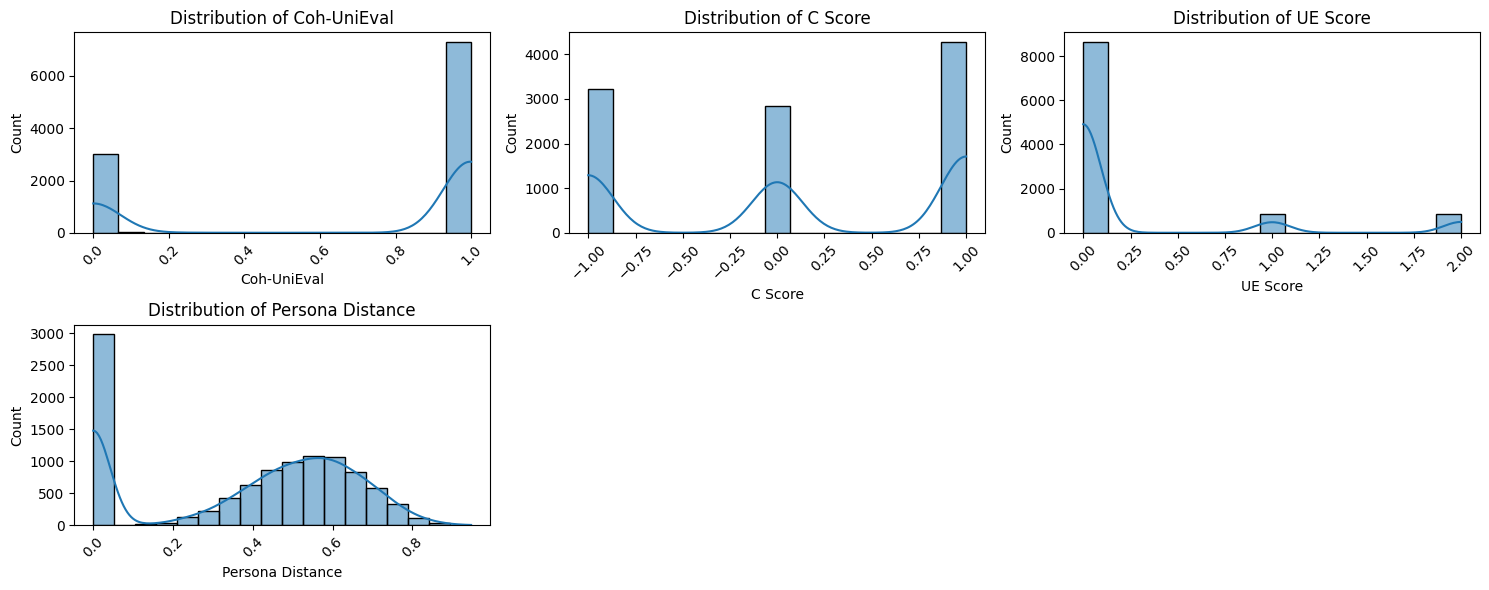

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_analyze = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

plt.figure(figsize=(15, 5*len(columns_to_analyze)//3))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze)//3 + 1, 3, i)
    sns.histplot(data= df, x=column, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
import re
import json

# def is_single_valid_json_response(response_text: str) -> bool:
#     """
#     Ensures there is exactly one valid JSON object in the text
#     and it contains the 'response' key.
#     """
#     # Regex pattern to find all JSON-like blocks
#     json_pattern = r'\{.*?"response"\s*:\s*".*?".*?\}'
#     matches = re.findall(json_pattern, response_text, re.DOTALL)

#     # Must be exactly one match
#     if len(matches) != 1:
#         return False

#     try:
#         parsed_json = json.loads(matches[0])
#         return "response" in parsed_json
#     except json.JSONDecodeError:
#         return False


# def format_quality_score(response_text: str) -> float:
#     """
#     Returns:
#     - 1.0 for valid, informative JSON
#     - 0.3 for short but valid JSON
#     - 0.1 for multiple JSONs
#     - 0.0 for invalid/no JSON
#     """
#     json_pattern = r'\{.*?"response"\s*:\s*".*?".*?\}'
#     matches = re.findall(json_pattern, response_text, re.DOTALL)

#     if len(matches) == 1:
#         try:
#             parsed = json.loads(matches[0])
#             response_len = len(parsed["response"])
#             if response_len >= 30:
#                 return 1.0
#             else:
#                 return 0.3  # Short, but valid
#         except json.JSONDecodeError:
#             return 0.0  # Invalid JSON
#     elif len(matches) > 1:
#         return 0.1  # Penalize multiple objects
#     else:
#         return 0.0  # No valid match


import re
import json

def instructability_score(response_text: str, avg_len: int) -> float:
    """
    Encourages responses that:
    - Are close in word length to avg_len
    - Optionally follow valid JSON format with a 'response' key

    The score prioritizes length alignment and rewards well-formed output with a small bonus.
    """
    # Step 1: Length-based scoring
    word_count = len(str(response_text).split())
    deviation = abs(word_count - avg_len) / avg_len
    length_score = max(0.0, 1.0 - deviation**2)  # quadratic penalty

    # Step 2: Check for valid single JSON with "response" key
    json_pattern = r'\{.*?"response"\s*:\s*".*?".*?\}'
    matches = re.findall(json_pattern, response_text, re.DOTALL)

    json_bonus = 0.0
    if len(matches) == 1:
        try:
            parsed = json.loads(matches[0])
            if "response" in parsed:
                json_bonus = 0.3  # Encourage JSON format but don’t overemphasize
        except json.JSONDecodeError:
            pass

    # Step 3: Combine and clip
    score = length_score + json_bonus
    return round(score, 3)


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Step 2: Normalize metrics to [0, 1]
metrics = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])

# Compute response length in number of words
df.rename(columns={"gen_response": "response"}, inplace=True)

avg_len = int(df["response"].apply(lambda x: len(str(x).split())).mean())

# Valid JSON format → 1.0, otherwise 0.0
df["instructability"] = df["response"].apply(lambda r: instructability_score(r, avg_len))

# Prioritizing the Response Length
df["quality_score"] = (
    0.14 * df["Coh-UniEval"] +
    0.20 * df["C Score"] +
    0.18  * df["UE Score"] +
    0.16  * df["Persona Distance"] + 
    0.32 * df["instructability"]
)

display(df[["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "instructability", "quality_score"]].head())

df.drop(columns=["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "instructability"], inplace=True)

df.drop(columns=["act_response", "response_time"], inplace=True)
print(df.shape)

,Coh-UniEval,C Score,UE Score,Persona Distance,instructability,quality_score
0,0.999912,0.5,0.0,0.399985,0.997,0.623025
1,0.999077,1.0,0.0,0.707204,0.909,0.743903
2,0.997008,0.5,0.5,0.483180,0.795,0.661290
3,0.999672,1.0,0.0,0.499546,0.871,0.698601
4,0.998717,1.0,0.0,0.656254,0.759,0.687701


(10347, 5)


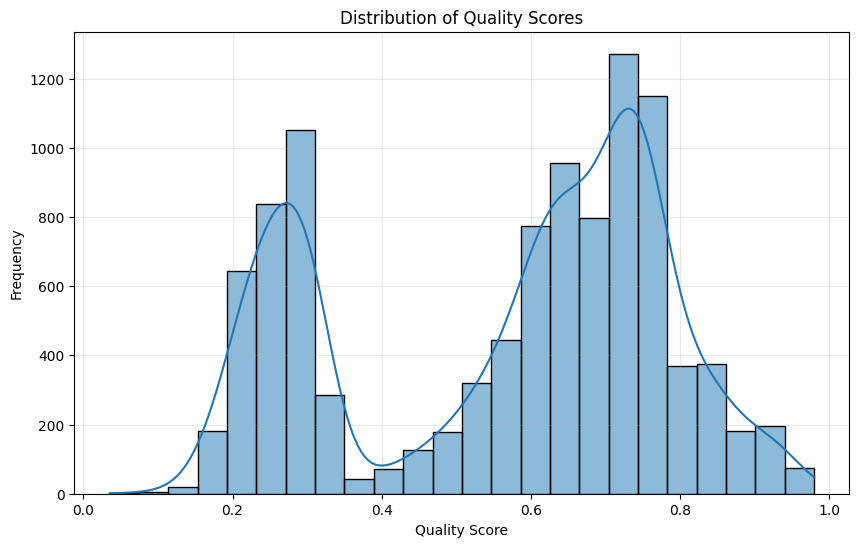

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['quality_score'], kde=True)
plt.title('Distribution of Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
# Function to generate a prompt
def create_dpo_prompt(personas, context, _COT):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if _COT == "-COT":
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if _COT == "-COT":
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [23]:
# Step 4: Prepare prompt and extract unique pairs

# # Apply to your dataframe
df["prompt"] = df.apply(lambda row: create_dpo_prompt(row["personas"], row["context"], _COT), axis=1)

# Get unique (personas, context) pairs
unique_pairs = df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(unique_pairs)}")
print("df shape:", df.shape)

df.head(3)

Total unique context-persona pairs: 1500
df shape: (10347, 5)


,personas,context,response,prompt,quality_score
0,I collect lighthouses.Ive never been to to Eng...,"User1: Wow, this is amazing! What is this?\nUs...","Yes, this lighthouse has made appearances on t...",I will provide you with a conversation context...,0.623025
1,I would like to visit Colorado.I love Bavarian...,"User1: I know this place, but I dont remember ...","Yes, ski lessons are available at Vail Ski Res...",I will provide you with a conversation context...,0.743903
2,I would like to live in a house.I wish to visi...,User1: Where is this place?\nUser2: This is Gr...,The formal garden at Greenmount Homestead feat...,I will provide you with a conversation context...,0.661290


In [24]:
from tqdm import tqdm

# Quantile thresholds
q_low = df["quality_score"].quantile(0.4)
q_high = df["quality_score"].quantile(0.6)

# Filter to exclude mid-range responses
eligible_df = df[
    (df["quality_score"] <= q_low) | (df["quality_score"] >= q_high)
]

# Prepare DPO records
dpo_records = []

for _, pair in tqdm(unique_pairs.iterrows(), total=len(unique_pairs)):
    sub_df = eligible_df[
        (eligible_df["personas"] == pair["personas"]) &
        (eligible_df["context"] == pair["context"])
    ]

    high_quality = sub_df[sub_df["quality_score"] >= q_high]
    low_quality = sub_df[sub_df["quality_score"] <= q_low]

    for _, chosen_row in high_quality.iterrows():
        for _, rejected_row in low_quality.iterrows():
            dpo_records.append({
                "prompt": create_dpo_prompt(
                    personas=chosen_row["personas"],
                    context=chosen_row["context"],
                    _COT=_COT  # This variable must be defined earlier
                ),
                "chosen": json.dumps({"response": chosen_row["response"]}),
                "rejected": json.dumps({"response": rejected_row["response"]}),
                "score_chosen": round(chosen_row["quality_score"], 3),
                "score_rejected": round(rejected_row["quality_score"], 3)
            })

print(f"✅ Total DPO records prepared: {len(dpo_records)}")


  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:02<00:00, 638.59it/s]

✅ Total DPO records prepared: 9184


In [25]:
# Step 6: Final DataFrame
import pandas as pd

dpo_weighted_df = pd.DataFrame(dpo_records)

print(f"Final weighted DPO dataset shape: {dpo_weighted_df.shape}")

# Save weighted DPO dataset
dpo_weighted_df.to_csv(f"dpo_datasets/{DATASET}_perso_dpo.csv", index=False)

dpo_weighted_df.head(20)

Final weighted DPO dataset shape: (9184, 5)


,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,"{""response"": ""The South Foreland Lighthouse is...","{""response"": ""I would love to visit the South ...",0.695,0.575
1,I will provide you with a conversation context...,"{""response"": ""The South Foreland Lighthouse is...","{""response"": ""The South Foreland Lighthouse, b...",0.695,0.294
2,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""I would love to visit the South ...",0.756,0.575
3,I will provide you with a conversation context...,"{""response"": ""As a fellow lighthouse enthusias...","{""response"": ""The South Foreland Lighthouse, b...",0.756,0.294
4,I will provide you with a conversation context...,"{""response"": ""Yes, ski lessons are available a...","{""response"": ""provide the personalized natural...",0.744,0.306
5,I will provide you with a conversation context...,"{""response"": ""Yes, ski lessons are available a...","{""response"": ""Vail Ski Resort is situated at a...",0.744,0.577
6,I will provide you with a conversation context...,"{""response"": ""Vail Ski Resort in Colorado is t...","{""response"": ""provide the personalized natural...",0.766,0.306
7,I will provide you with a conversation context...,"{""response"": ""Vail Ski Resort in Colorado is t...","{""response"": ""Vail Ski Resort is situated at a...",0.766,0.577
8,I will provide you with a conversation context...,"{""response"": ""Vail Ski Resort in Colorado offe...","{""response"": ""provide the personalized natural...",0.749,0.306
9,I will provide you with a conversation context...,"{""response"": ""Vail Ski Resort in Colorado offe...","{""response"": ""Vail Ski Resort is situated at a...",0.749,0.577
